<a href="https://colab.research.google.com/github/PriyaMaan/LandRegistryProject/blob/main/HotelBooking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# Load dataset
data_url = "/content/hotel_bookings.csv"
df = pd.read_csv(data_url)

# Display initial dataset info
print("Initial Dataset Info:")
print(df.info())

# Handle missing values
## Fill missing values with appropriate placeholders
## Categorical columns: Fill with 'Unknown'
## Numerical columns: Fill with median values
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna('Unknown', inplace=True)
    else:
        df[column].fillna(df[column].median(), inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Convert date columns to proper datetime format (if applicable)
date_columns = ['reservation_status_date']  # Modify based on dataset
df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')

# Standardizing column names (lowercase and replacing spaces with underscores)
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Save cleaned dataset
df.to_csv("cleaned_hotel_bookings.csv", index=False)

print("Data Cleaning Complete. Cleaned dataset saved as 'cleaned_hotel_bookings.csv'")
print("Updated Dataset Info:")
print(df.info())


Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  

<ipython-input-1-e149b30561b0>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna('Unknown', inplace=True)
<ipython-input-1-e149b30561b0>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

Data Cleaning Complete. Cleaned dataset saved as 'cleaned_hotel_bookings.csv'
Updated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 87396 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           87396 non-null  object        
 1   is_canceled                     87396 non-null  int64         
 2   lead_time                       87396 non-null  int64         
 3   arrival_date_year               87396 non-null  int64         
 4   arrival_date_month              87396 non-null  object        
 5   arrival_date_week_number        87396 non-null  int64         
 6   arrival_date_day_of_month       87396 non-null  int64         
 7   stays_in_weekend_nights         87396 non-null  int64         
 8   stays_in_week_nights            87396 non-null  int64         
 9   adults                          87396 non-

Precomputed analytics saved successfully.


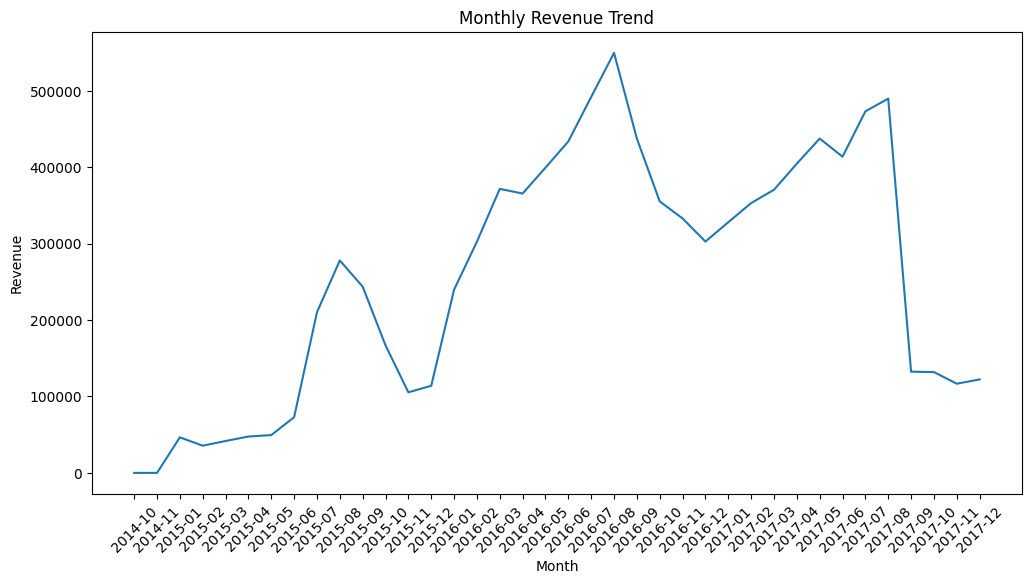

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv("cleaned_hotel_bookings.csv")

# Convert date column back to datetime
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# 1. Compute Revenue Trends
df['revenue'] = df['adr'] * df['stays_in_weekend_nights'] + df['stays_in_week_nights']
revenue_trend = df.groupby(df['reservation_status_date'].dt.to_period('M'))['revenue'].sum()
revenue_trend.to_csv("precomputed_revenue_trend.csv")

# 2. Compute Cancellation Rate
cancellation_rate = (df['is_canceled'].sum() / len(df)) * 100
with open("precomputed_cancellation_rate.txt", "w") as f:
    f.write(f"Cancellation Rate: {cancellation_rate:.2f}%\n")

# 3. Compute Geographical Distribution
geo_distribution = df['country'].value_counts()
geo_distribution.to_csv("precomputed_geo_distribution.csv")

# 4. Compute Booking Lead Time Distribution
lead_time_distribution = df['lead_time'].describe()
lead_time_distribution.to_csv("precomputed_lead_time_distribution.csv")

# Plot Revenue Trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=revenue_trend.index.astype(str), y=revenue_trend.values)
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.savefig("revenue_trend_plot.png")

print("Precomputed analytics saved successfully.")


In [3]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 66.4 MB/s eta 0:00:00


In [4]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import pandas as pd

# Load cleaned dataset
df = pd.read_csv("cleaned_hotel_bookings.csv")

# Convert relevant text data into embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
text_data = df[['hotel', 'reservation_status', 'country', 'customer_type', 'market_segment']].astype(str).agg(' '.join, axis=1).tolist()
embeddings = model.encode(text_data, convert_to_numpy=True, normalize_embeddings=True)

# Create FAISS index for fast retrieval
d, num_embeddings = embeddings.shape
index = faiss.IndexFlatL2(num_embeddings)
index.add(embeddings)
faiss.write_index(index, "vector_database.index")

# Function to retrieve similar records
def search_similar(query, top_k=5):
    """
    Searches for the top_k most similar records based on the given query.
    :param query: The user input query (string).
    :param top_k: Number of results to return.
    :return: DataFrame with relevant search results.
    """
    query_embedding = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    distances, indices = index.search(query_embedding, top_k)
    results = df.iloc[indices[0]]
    return results[['hotel', 'reservation_status', 'country', 'customer_type', 'market_segment']]

# Example Queries
test_queries = [
    "Canceled bookings in Portugal",
    "Transient customer bookings",
    "Bookings from direct market segment"
]

for query in test_queries:
    print(f"Query: {query}")
    print(search_similar(query))
    print("-" * 50)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Query: Canceled bookings in Portugal
              hotel reservation_status country customer_type market_segment
9473   Resort Hotel           Canceled     NOR     Transient         Direct
28978  Resort Hotel           Canceled     AGO     Transient         Direct
5172   Resort Hotel           Canceled     CHE     Transient         Direct
6118   Resort Hotel           Canceled     CHE     Transient         Direct
8519   Resort Hotel           Canceled     CHE     Transient         Direct
--------------------------------------------------
Query: Transient customer bookings
              hotel reservation_status country    customer_type market_segment
23339  Resort Hotel          Check-Out     THA  Transient-Party         Direct
429    Resort Hotel          Check-Out     IRL  Transient-Party         Direct
431    Resort Hotel          Check-Out     IRL  Transient-Party         Direct
1460   Resort Hotel          Check-Out     IRL  Transient-Party         Direct
3902   Resort Hotel       

In [5]:
!pip install streamlit faiss-cpu sentence-transformers pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [9]:
!pip install streamlit faiss-cpu sentence-transformers pandas pyngrok

In [10]:
%%writefile query_interface.py
import streamlit as st
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer

# Load main dataset
df = pd.read_csv("cleaned_hotel_bookings.csv")

# Load precomputed insight files
canceled_by_date = pd.read_csv("insights_canceled_by_date.csv")
bookings_by_country = pd.read_csv("insights_by_country.csv")
bookings_by_customer_type = pd.read_csv("insights_by_customer_type.csv")
bookings_by_market_segment = pd.read_csv("insights_by_market_segment.csv")

# Load sentence transformer and FAISS index
model = SentenceTransformer("all-MiniLM-L6-v2")
index = faiss.read_index("vector_database.index")

# FAISS-based semantic search
def search_similar(query, top_k=5):
    query_embedding = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    distances, indices = index.search(query_embedding, top_k)
    results = df.iloc[indices[0]]
    return results[['hotel', 'reservation_status', 'country', 'customer_type', 'market_segment']]

# Precomputed insight matcher
def serve_precomputed_insight(query):
    query = query.lower()

    if "canceled" in query and "date" in query:
        return canceled_by_date
    elif "country" in query:
        return bookings_by_country
    elif "customer type" in query or "customer" in query:
        return bookings_by_customer_type
    elif "market segment" in query or "segment" in query:
        return bookings_by_market_segment
    else:
        return None

# Streamlit UI
def main():
    st.title("🔍 Hotel Booking Query System")
    st.write("Ask questions about the hotel booking data – powered by precomputed insights & semantic search.")

    query = st.text_input("Enter your query", "Canceled bookings in Portugal")
    top_k = st.slider("Top K results", 1, 10, 5)

    if st.button("Search"):
        # Check if query matches any precomputed insights
        insight_result = serve_precomputed_insight(query)

        if insight_result is not None:
            st.subheader("📊 Precomputed Insight")
            st.dataframe(insight_result)
        else:
            st.subheader("🧠 Results via Semantic Search (RAG)")
            results = search_similar(query, top_k)
            st.dataframe(results)

if __name__ == "__main__":
    main()


Writing query_interface.py


In [14]:
import pandas as pd

# Load cleaned dataset
df = pd.read_csv("cleaned_hotel_bookings.csv")

# Precompute Canceled Bookings by Date
canceled_by_date = df[df['reservation_status'] == 'Canceled'].groupby('reservation_status_date').size().reset_index(name='canceled_count')

# Precompute Bookings by Country
bookings_by_country = df.groupby('country').size().reset_index(name='total_bookings')

# Precompute Customer Type Insights
bookings_by_customer_type = df.groupby('customer_type').size().reset_index(name='total_bookings')

# Precompute Market Segment Insights
bookings_by_market_segment = df.groupby('market_segment').size().reset_index(name='total_bookings')

# Save all insights to CSV files for later querying
canceled_by_date.to_csv("insights_canceled_by_date.csv", index=False)
bookings_by_country.to_csv("insights_by_country.csv", index=False)
bookings_by_customer_type.to_csv("insights_by_customer_type.csv", index=False)
bookings_by_market_segment.to_csv("insights_by_market_segment.csv", index=False)

print("✅ Insights precomputed and saved!")


✅ Insights precomputed and saved!


In [15]:
!streamlit run query_interface.py &>/dev/null &

In [16]:
!ngrok config add-authtoken 2vFXgLi6LQhGYEtAttxfnmkkGXH_4kCEjpUk5pf3e6STzFWXT

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [18]:
from pyngrok import ngrok

# Kill any previous tunnels
ngrok.kill()

# Create a new public URL for the Streamlit app
public_url = ngrok.connect(8501)
print(f"Streamlit App URL: {public_url}")

Streamlit App URL: NgrokTunnel: "https://7980-34-90-108-169.ngrok-free.app" -> "http://localhost:8501"
